In [4]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from tqdm import tqdm
import matplotlib.pyplot as plt
import scipy.linalg
import random

In [317]:
#constants
S0 = 172
X = 35000
T = 100
N = 100
deltaT = T/N
c = 2.5e-7
sigma = np.array([3.51e-3, 3.3e-2,1.172e-1])
eta = np.array([1e-6,5e-6,25e-6])
matrix_sigma = np.array([[0.9349, 0.0434, 0.0217],[0.7164, 0.2239, 0.0597],[0.4400, 0.4800, 0.0800]])
matrix_eta = np.array([[0.50, 0.30, 0.20],[0.15, 0.80, 0.05],[0.05, 0.05, 0.90]])

In [6]:
# Function to generate a path based on matrix_sigma values
def sigma_path(matrix_sigma, n):
    # Initialize an array to store the path
    sigma_p = np.zeros(n)

    # Define the starting state for sigma
    StartingState = 0  # low 
    CurrentState = StartingState
    
    # Set the starting state in the path array
    sigma_p[0] = CurrentState
    
    # Loop to generate the path based on transition probabilities
    i = 1
    while i < n:
        # Randomly select the next state based on transition probabilities
        CurrentState = np.random.choice([0, 1, 2], p=matrix_sigma[CurrentState])
        # Store the state in the path array
        sigma_p[i] = CurrentState
        i += 1
    
    return sigma_p

def eta_path(matrix_eta,n):
  eta_p = np.zeros(n)
  StartingState = 0 
  CurrentState = StartingState
  eta_p[0] = CurrentState
  i=1
  while i<n:
    CurrentState = np.random.choice([0, 1, 2], p=matrix_eta[CurrentState])
    eta_p[i] = CurrentState
    i += 1
  return eta_p

def xi_path(n):
    # Generate random samples from a normal distribution
    return np.random.normal(0, 1, n)

In [7]:
def cost_function(x_p, sigma_p, eta_p, xi_p):
  # Adjusted eta values
  eta_tilda = eta_p - c/2
  
  # Append a zero to the end of x_p array
  x_p0 = np.append(x_p,0)
  sum_term = np.diff(-(x_p0))**2*eta_tilda - x_p*sigma_p*xi_p
  
  # Calculate the cost function
  Cx = c*X**2/2 + np.sum(sum_term)
  return Cx

# Constant Speed Strategy and Optimal Risk Neutral Strategy

In [8]:
def simulation(xn, size):
  C_size = np.zeros(size)
  for i in tqdm(range(size)):
    C_size[i] = cost_function(xn, sigma[sigma_path(matrix_sigma,N).astype(int)], eta[eta_path(matrix_eta,N).astype(int)], xi_path(N))
  return C_size

In [9]:
def risk_neutral_const_eta():
  n = np.arange(0,N)
  xn_star = X*(N-n)/N
  return xn_star

In [87]:
def plot_shares(xn, ls, *lb):
  n = np.arange(0,N+1)
  plt.plot(n, xn/X, linestyle=ls, label = lb)

In [11]:
def plot_histogram(x):
  plt.hist(x, bins=40,rwidth=0.75, label = 'Std C(x) = {std:.0f}$'.format(std = np.std(x,ddof=1)))
  plt.axvline(np.mean(x),color = 'red',linestyle='dashed',label = 'Mean C(x) = {mean:.0f}$'.format(mean = np.mean(x)))
  plt.legend()

In [59]:
def E_v_eta(v):
  p = matrix_eta[v]
  return np.dot(p, eta)-c/2

def E_v_eta(v):
    # Retrieve transition probabilities for a given state 'v'
    p = matrix_eta[v]
    
    # Calculate the dot product of transition probabilities and eta, subtracted by c/2
    return np.dot(p, eta) - c/2

def a_seq_backward():
  # Initialize a sequence of values for each state 'v' at each time 'n'
  a_seq = np.zeros((N, 3))  # a_n^(v)
  
  # Define states 'v'
  v = np.arange(0, 3)
  
  # Calculate E[v, N-1]
  E_v_Nm1 = E_v_eta(v)

  # Set values for the last time step (N-1)
  a_seq[N - 1] = eta - c/2
  
  # Iterate backward through time steps from N-2 to 0
  n = N - 2
  while n > -1:
    for v in range(3):
      sum_term = 0
      
      # Calculate sum_term by iterating over all possible states 'w'
      for w in range(3):
        a_w = a_seq[n + 1]
        sum_term += matrix_eta[w, v] * a_w[w]
          
      # Update the value for the current time step 'n' and state 'v'
      a_seq[n, v] = (E_v_Nm1[v] * sum_term) / (E_v_Nm1[v] + sum_term)
  
    # Move to the previous time step
    n -= 1
  return a_seq

In [61]:
def risk_neutral_non_const(a_seq,v):
  # Calculate E[v, N-1]
  E_v_Nm1 = E_v_eta(v)
  xn_star = np.zeros(N)
  xn_star[0] = X

  # Loop through time steps from 1 to N-1
  for n in range(1,N):
    a_w = a_seq[n] # Retrieve a_seq values for time step 'n'
    sum_term = 0
    # Calculate sum_term by iterating over all possible states 'w'
    for w in range(3):
      sum_term += matrix_eta[w,v[n]]*a_w[w]
    # Update the value of xn_star for the current time step 'n'
    xn_star[n] = xn_star[n-1]*(E_v_Nm1[n]/(E_v_Nm1[n]+sum_term))
  return xn_star

In [60]:
constant_speed_xn=risk_neutral_const_eta()

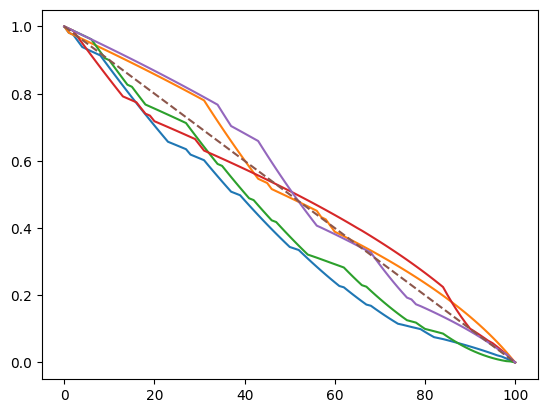

In [79]:
for i in range(5):
  v = eta_path(matrix_eta,N).astype(int)
  a_seq = a_seq_backward()
  x_star = risk_neutral_non_const(a_seq,v)
  plot_shares(np.append(x_star,0),"solid")
plot_shares(np.append(constant_speed_xn,0),"dashed")

In [14]:
def simulation_12(size):
  C1_size = np.zeros(size)
  C2_size = np.zeros(size)
  x_ns = []
  n = np.arange(0,N)
  xn = X*(N-n)/N
  for i in tqdm(range(size)):
    s_i = sigma_path(matrix_sigma,N).astype(int)
    e_i = eta_path(matrix_eta,N).astype(int)
    xi = xi_path(N)
    a_seq = a_seq_backward()
    x_star = risk_neutral_non_const(a_seq,e_i)
    x_ns.append(x_star)
    C1_size[i] = cost_function(xn, sigma[s_i], eta[e_i], xi)
    C2_size[i] = cost_function(x_star, sigma[s_i], eta[e_i], xi)
  return C1_size, C2_size, x_ns

In [14]:
sim12 = simulation_12(size=50000)

  0%|          | 35/50000 [00:00<04:46, 174.23it/s]

100%|██████████| 50000/50000 [04:40<00:00, 178.46it/s]


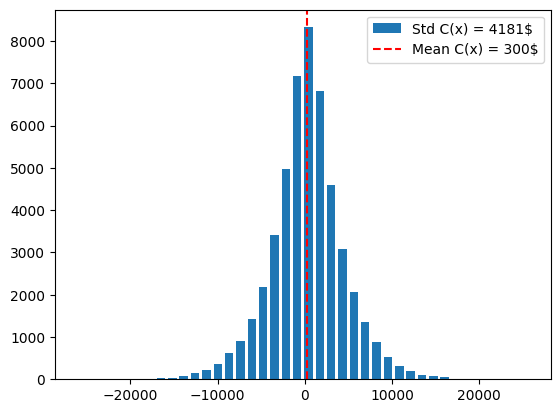

In [15]:
plot_histogram(sim12[0])

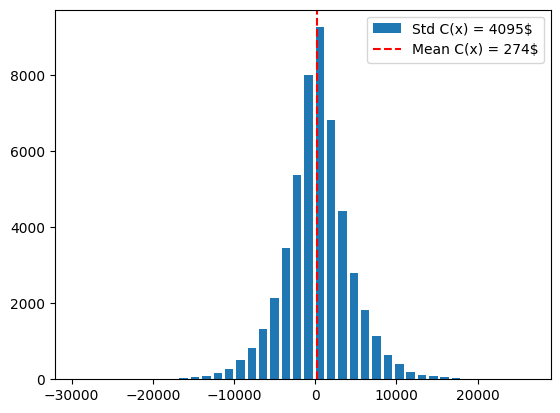

In [16]:
plot_histogram(sim12[1])

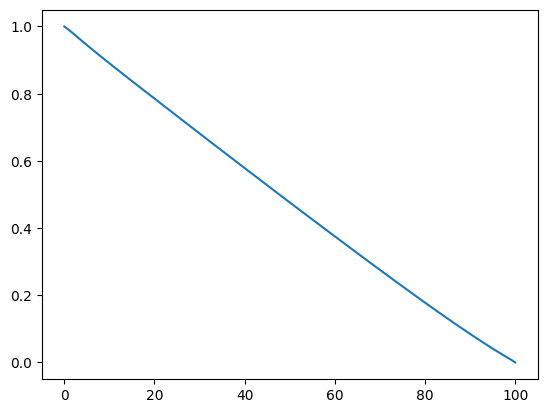

In [17]:
xns = np.array(sim12[2])
plot_shares(np.append(np.mean(xns,axis=0),0),"solid")

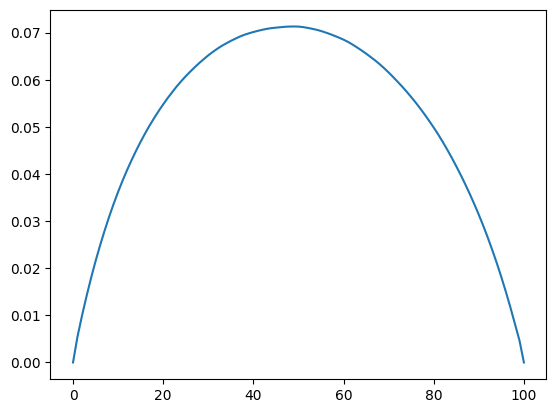

In [18]:
plot_shares(np.append(np.std(xns,axis=0,ddof=1),0),"solid")

# Expected Exponential Cost

### Almgren-Chriss strategy -- constant $\sigma,\eta$

In [15]:
alpha_list = [2e-6, 1e-5, 2e-5]

In [314]:
def x_star_exp(kappa):
  n = np.arange(0,N)
  return np.sinh(kappa*(T-n*deltaT))/np.sinh(kappa*T)*X

In [315]:
def kappa_n(sigma_m, eta_m, alpha):
  x = alpha*sigma_m**2*deltaT
  y = 4*eta_m-2*c
  z = x/y+1
  return np.arccosh(z)/deltaT

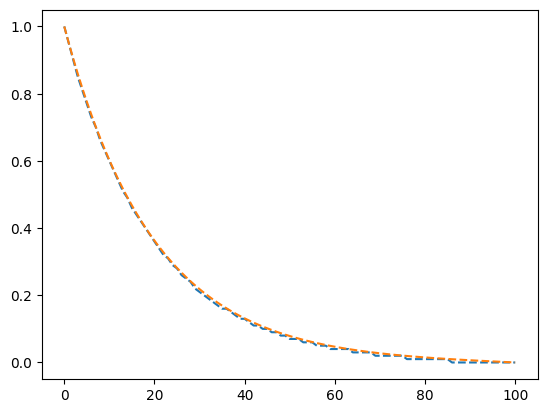

In [318]:
alpha = alpha_list[2]
kappa_p = kappa_n(np.mean(sigma), np.mean(eta), alpha)
x_n_AC = x_star_exp(kappa_p)
x_1 = np.array(x_n_AC*100/35000,dtype=int)*350
plot_shares(np.append(x_1,0),"dashed")
plot_shares(np.append(x_n_AC,0),"dashed")

In [24]:
alpha = 1e-8
#the article use alpha = 2e-5 but I didn't replicate the same result
#the following plot is closer to the plot in the paper from alpha = 1e-8

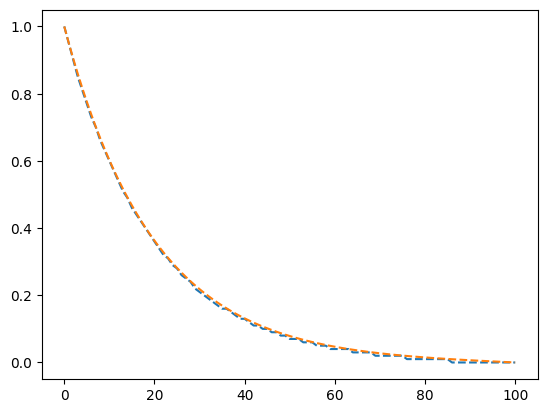

In [319]:
kappa_p = kappa_n(np.mean(sigma), np.mean(eta), alpha)
x_n_AC = x_star_exp(kappa_p)
x_1 = np.array(x_n_AC*100/35000,dtype=int)*350
plot_shares(np.append(x_1,0),"dashed")
plot_shares(np.append(x_n_AC,0),"dashed")

In [18]:
def simulation_3(x_n_AC, size):
  C2_size = np.zeros(size)

  n = np.arange(0,N)
  xn = X*(N-n)/N
  for i in tqdm(range(size)):
    s_i = sigma_path(matrix_sigma,N).astype(int)
    e_i = eta_path(matrix_eta,N).astype(int)
    xi = xi_path(N)
    C2_size[i] = cost_function(x_n_AC, sigma[s_i], eta[e_i], xi)
  return C2_size

Try constant $\sigma, \eta$, no v/w anymore. Theorem 4.1 becomes:
for all n-1 we need to find all $0 \le x_{n-1} \le X$, for each $x_{n-1}$, find $x_n^*$ from calculating all $x_n$ for all $0 \le x_{n} \le x_{n-1}$ and corresponding J then we have all J_n-1 for all x_n-1

Once we have all J_n we could solve x_n* from x0 to x1* to...x_N-1

In [19]:
def min_finder(J):
  return np.argmin(J)

In [20]:
eta_mean = np.mean(eta)
sigma_mean = np.mean(sigma)
def constant_vol_liq(x_n, x_n_1):
  return np.exp(alpha*(x_n-x_n_1)**2*(eta_mean-c/2)+1/2*(x_n*alpha*sigma_mean)**2*deltaT)

In [21]:
def J_value_function(J_n,grid_length):
  #Given Jn find Jn-1 by computing all xn-1 and optimize xn
  J_n_1 = np.ones(X//grid_length+1)
  x_possible = np.arange(0,X+grid_length,grid_length)
  for x_n_1 in x_possible:
    if x_n_1 == 0:
      x_n = 0
      x_n_index = 0
      continue
    else:
      x_n = np.arange(0,x_n_1+grid_length,grid_length)
      x_n_index = np.arange(0,x_n_1//grid_length+1).astype(int)
    J_value = constant_vol_liq(x_n, x_n_1)*J_n[x_n_index]
    min_index = min_finder(J_value)
    J_n_1[x_n_index[-1]] = J_value[min_index]
  return J_n_1

In [22]:
def J_value(alpha,grid_length):
    # compute the J matrix for all n from 1 to 100
    J = list(range(100))
    x_Np1 = np.arange(0,X+grid_length,grid_length)
    J_Np1 = np.exp(alpha*x_Np1**2*(eta_mean-c/2))
    J[0] = J_value_function(J_Np1,grid_length)
    for i in tqdm(range(1,100)):
        J[i] = J_value_function(J[i-1],grid_length)
    J = np.array(J)
    return J

In [23]:
def backward_optimize_x(J,grid_length):
    #backward from x1 to xN-1
    x_arr = np.zeros(100)
    x_possible = np.arange(0,X+grid_length,grid_length)
    x_arr[0] = x_possible[np.argmin(constant_vol_liq(x_possible,X)*J[99])]
    for i in range(1,100):
        x_i_available = np.arange(0,x_arr[i-1]+grid_length,grid_length).astype(int)
        x_i_available_index = np.arange(0,x_arr[i-1]/grid_length+1).astype(int)
        x_arr[i] = x_i_available[np.argmin(constant_vol_liq(x_i_available,x_arr[i-1])*J[99-i,x_i_available_index])]
    return x_arr

In [32]:
alpha = 1e-5
J = J_value(alpha,35)
x_arr = backward_optimize_x(J,35)

  0%|          | 0/99 [00:00<?, ?it/s]

100%|██████████| 99/99 [00:03<00:00, 29.70it/s]


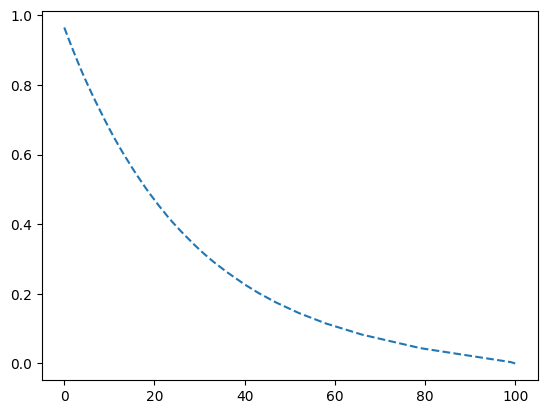

In [33]:
plot_shares(np.append(x_arr,0),"dashed")
# the result are same as from Almgren-Chriss when constant sigma/eta

Build $J_v^{N-1}(x_{N-1})$

In [24]:
def stochastic_vol_liq(v1,v2,x_n,x_n_1,alpha,x_n_index,J_n):
  sum_term = 0
  # Iterate through possible states 'w1' and 'w2'
  for w1 in range(3):
    for w2 in range(3):
      # Calculate the sum_term
      sum_term += matrix_eta[w2,v2]*matrix_sigma[w1,v1]*np.exp(alpha*(x_n_1-x_n)**2*(eta[w2]-c/2)+1/2*(x_n*alpha*sigma[w1])**2*deltaT)*J_n[x_n_index,w1,w2]
  return sum_term

In [25]:
def stochastic_J_value_function(J_n,grid_length,alpha):
  # Given Jn find Jn-1 by computing all xn-1 and optimize xn, under stochastic vol/liq
  # Calculate the size of the grid based on X and grid_length
  grid_size = X//grid_length+1

  # Initialize J_n_1 array for the next time step
  J_n_1 = np.zeros((grid_size,3,3))

  # Generate possible x_n_1 values based on grid_length
  x_possible = np.arange(0,X+grid_length,grid_length)
  for x_n_1 in x_possible:
    if x_n_1 == 0:
      x_n = 0
      x_n_index = 0
      #continue
    else:
      x_n = np.arange(0,x_n_1+grid_length,grid_length)
      x_n_index = np.arange(0,x_n_1//grid_length+1).astype(int)
    J_value = np.zeros((x_n_1//grid_length+1,3,3))

    # Calculate J_value for different v1 and v2
    for v1 in range(3):
      for v2 in range(3):
        J_value[:,v1,v2] = stochastic_vol_liq(v1,v2,x_n,x_n_1,alpha,x_n_index,J_n)
        # Find the index of the minimum value in J_value for each v1, v2 pair
        min_index = min_finder(J_value[:,v1,v2])
        # Update J_n_1 based on the calculated minimum index
        if np.size(x_n_index)>1:
          J_n_1[x_n_index[-1],v1,v2] = J_value[min_index,v1,v2]
        else:
          J_n_1[x_n_index,v1,v2] = J_value[min_index,v1,v2]
  return J_n_1

In [80]:
def stochastic_J_value(alpha,grid_length):
    # compute the J matrix for all n from 1 to 100
    J = list(range(100))
    x_Np1 = np.arange(0,X+grid_length,grid_length)
    grid_size = X//grid_length+1
    # Initialize J_N(Np1) matrix for the last time step N
    J_Np1 = np.zeros((grid_size,3,3))

    # Calculate J_N(Np1) matrix for the last time step based on x_N
    for v1 in range(3):
        for v2 in range(3):
            sum_term = 0
            for w1 in range(3):
                for w2 in range(3):
                    sum_term += matrix_eta[w2,v2]*matrix_sigma[w1,v1]*np.exp(alpha*x_Np1**2*(eta[w2]-c/2))
            J_Np1[:,v1,v2] = sum_term
    # Calculate J matrices for time steps from 1 to 100 using stochastic_J_value_function
    J[0] = stochastic_J_value_function(J_Np1,grid_length,alpha)
    for i in tqdm(range(1,100)):
        J[i] = stochastic_J_value_function(J[i-1],grid_length,alpha)
    J = np.array(J)
    return J

In [27]:
def stochastic_backward_optimize(v1_path,v2_path,J,grid_length,alpha):
    # Backward from x1 to xN-1
    # Initialize an array 'x_arr' to store optimized x values from x1 to xN-1
    x_arr = np.zeros(100)

    # Generate possible values for x from 0 to X based on grid_length
    x_possible = np.arange(0,X+grid_length,grid_length)
    x_possible_index = np.arange(0,X//grid_length+1)

    # Initialize initial states v1 and v2 from the paths
    v1,v2 = v1_path[0],v2_path[0]
    # Calculate x1 based on stochastic_vol_liq and the last time step J matrix
    x_arr[0] = x_possible[np.argmin(stochastic_vol_liq(v1,v2,x_possible,X,alpha,x_possible_index,J[99]))]
    
    # Iterate from time step 2 to time step N
    for i in range(1,100):
        # Determine available x values up to time step 'i' based on x_arr[i-1]
        x_i_available = np.arange(0,x_arr[i-1]+grid_length,grid_length).astype(int)
        x_i_available_index = np.arange(0,x_arr[i-1]/grid_length+1).astype(int)
        # Get the corresponding v1 and v2 values from the paths
        v1,v2 = v1_path[i],v2_path[i]
        # Calculate optimal x values for time steps from 2 to N based on stochastic_vol_liq and J matrices
        x_arr[i] = x_i_available[np.argmin(stochastic_vol_liq(v1,v2,x_i_available,x_arr[i-1],alpha,x_i_available_index,J[99-i]))]
    return x_arr

In [81]:
def simulation_stochastic_exp_cost(alpha, grid_length, size):
  C1_size = np.zeros(size)
  C2_size = np.zeros(size)
  kappa_p = kappa_n(np.mean(sigma), np.mean(eta), alpha)
  x_n_AC = x_star_exp(kappa_p)
  x_1 = np.array(x_n_AC*100/35000,dtype=int)*350
  x_ns = []

  J = stochastic_J_value(alpha,grid_length)
  for i in tqdm(range(size)):
    s_i = sigma_path(matrix_sigma,N).astype(int)
    e_i = eta_path(matrix_eta,N).astype(int)
    xi = xi_path(N)
    x_star = stochastic_backward_optimize(s_i,e_i,J,grid_length,alpha)
    x_ns.append(x_star)
    C1_size[i] = cost_function(x_star, sigma[s_i], eta[e_i], xi)
    C2_size[i] = cost_function(x_1, sigma[s_i], eta[e_i], xi)
  return C1_size, C2_size, x_ns

In [125]:
grid_length = 350
simexp_lst = []
for alpha in alpha_list:
    simexp_lst.append(simulation_stochastic_exp_cost(alpha, grid_length, size=50000))

100%|██████████| 50000/50000 [13:15<00:00, 62.86it/s]


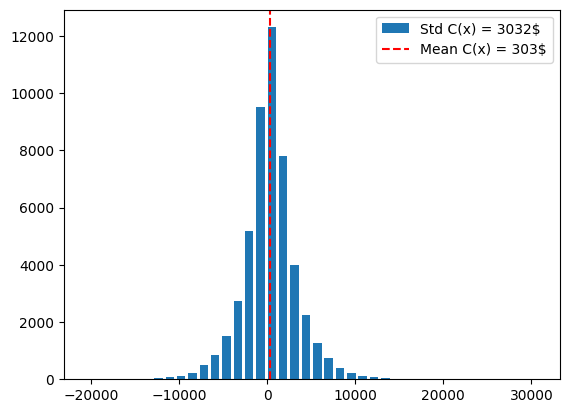

In [282]:
plot_histogram(simexp_lst[2][0])

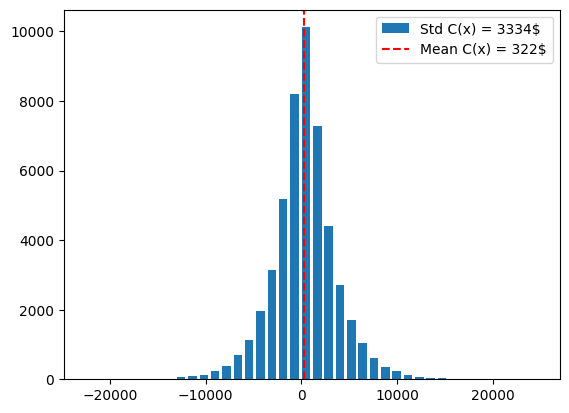

In [127]:
plot_histogram(simexp_lst[1][0])

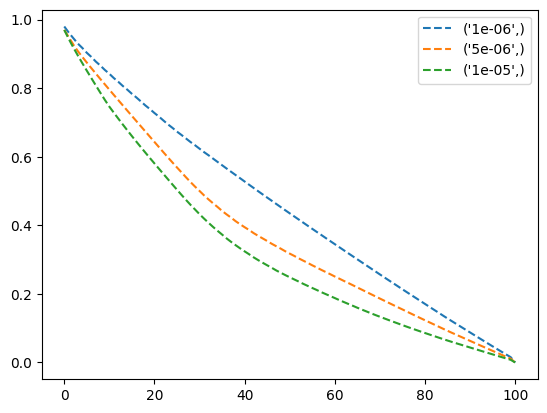

In [128]:
x_arr1 = np.array(simexp_lst[0][2])
x_arr2 = np.array(simexp_lst[1][2])
x_arr3 = np.array(simexp_lst[2][2])
plot_shares(np.append(np.mean(x_arr1,axis=0),0),"dashed",str(alpha_list[0]/2))
plot_shares(np.append(np.mean(x_arr2,axis=0),0),"dashed",str(alpha_list[1]/2))
plot_shares(np.append(np.mean(x_arr3,axis=0),0),"dashed",str(alpha_list[2]/2))
plt.legend()

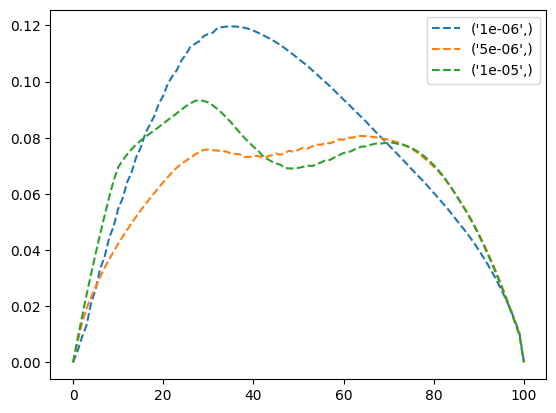

In [129]:
plot_shares(np.append(np.std(x_arr1,axis=0),0),"dashed",str(alpha_list[0]/2))
plot_shares(np.append(np.std(x_arr2,axis=0),0),"dashed",str(alpha_list[1]/2))
plot_shares(np.append(np.std(x_arr3,axis=0),0),"dashed",str(alpha_list[2]/2))
plt.legend()

In [ ]:
alpha = 2e-6
x_arr = backward_optimize_x(J,350)
J = stochastic_J_value(alpha,350)
for i in range(5):
    s_i = sigma_path(matrix_sigma,N).astype(int)
    e_i = eta_path(matrix_eta,N).astype(int)
    xi = xi_path(N)
    x_star = stochastic_backward_optimize(s_i,e_i,J,grid_length,alpha)
    plot_shares(np.append(x_star,0),"solid")


In [325]:
def x_star_exp_5(kappa):
  n = np.arange(0,N,N//5)
  return np.sinh(kappa*(T-n*deltaT))/np.sinh(kappa*T)*X

def plot_shares_5(xn, ls, *lb):
  n = np.arange(0,N+1,N//5)
  plt.plot(n, xn/X, linestyle=ls, label = lb)

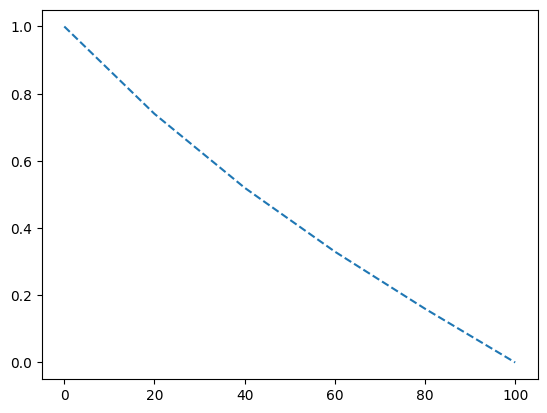

In [326]:
alpha = 1e-6
kappa_p = kappa_n(np.mean(sigma), np.mean(eta), alpha)
x_n_AC = x_star_exp_5(kappa_p)
x_1 = np.array(x_n_AC*100/35000,dtype=int)*350
plot_shares_5(np.append(x_1,0),"dashed")

In [337]:
def simulation_5(alpha, size):
  C1_size = np.zeros(size)
  kappa_p = kappa_n(np.mean(sigma), np.mean(eta), alpha)
  x_n_AC = x_star_exp_5(kappa_p)
  x_1 = np.array(x_n_AC*100/35000,dtype=int)*350
  for i in tqdm(range(size)):
    xi = xi_path(5)
    C1_size[i] = cost_function(x_1, np.mean(sigma), np.mean(eta), xi)
  return C1_size

In [340]:
x_1

array([35000, 25900, 18200, 11550,  5600])

In [364]:
A_sim = simulation_5(2, 50000)

100%|██████████| 50000/50000 [00:01<00:00, 28069.98it/s]


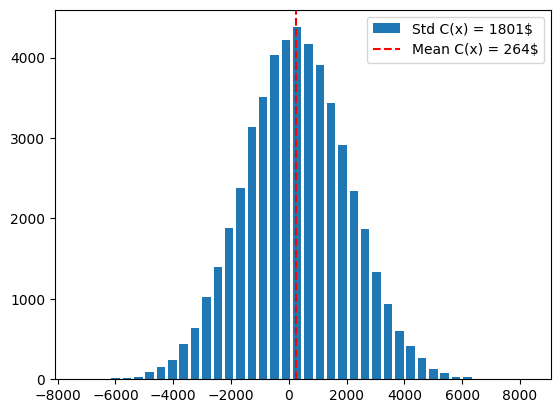

In [365]:
plot_histogram(A_sim-12380)

# Mean-Variance

## Restricted

In [ ]:
def Bellman_function(v1,v2,x_n,x_n_1,mu,lambda_,x_n_index,J_n,n):
  #v1 is the current state for sigma
  #v2 is the current state for eta
  #x_n is array for available x_n values, x_n_1 is fixed
  #mu, lambda_ are parameters
  #x_n_index is the index for x_n
  #J_n is value matrix from last iteration
  #n is current index
  #return J_n_1 value for v1,v2
  sum_term = 0
  for w1 in range(3):
    for w2 in range(3):
      sum_term += matrix_eta[w2,v2]*matrix_sigma[w1,v1]*J_n[x_n_index,w1,w2]
  E_v_eta = np.matmul(matrix_eta,(eta-c/2))[v2]
  E_v_eta2 = np.matmul(matrix_eta,(eta-c/2)**2)[v2]
  E_v_sigma = np.matmul(matrix_sigma,sigma**2)[v1]
  for i in range(1,N-n):
    E_v_eta_term += np.matmul(matrix_eta ,(eta-c/2)**2)[v2]
  return sum_term

In [30]:
def Bellman_J(J_n,grid_length,mu,lambda_):
  #Given Jn find Jn-1 by computing all xn-1 and optimize xn, under stochastic vol/liq
  grid_size = X//grid_length+1
  J_n_1 = np.zeros((grid_size,3,3))
  x_possible = np.arange(0,X+grid_length,grid_length)
  for x_n_1 in x_possible:
    if x_n_1 == 0:
      x_n = 0
      x_n_index = 0
      #continue
    else:
      x_n = np.arange(0,x_n_1+grid_length,grid_length)
      x_n_index = np.arange(0,x_n_1//grid_length+1).astype(int)
    J_value = np.zeros((x_n_1//grid_length+1,3,3))
    
    for v1 in range(3):
      for v2 in range(3):
        J_value[:,v1,v2] = Bellman_function(v1,v2,x_n,x_n_1,alpha,x_n_index,J_n)
        min_index = min_finder(J_value[:,v1,v2])
        if np.size(x_n_index)>1:
          J_n_1[x_n_index[-1],v1,v2] = J_value[min_index,v1,v2]
        else:
          J_n_1[x_n_index,v1,v2] = J_value[min_index,v1,v2]
  return J_n_1

In [29]:
def J_value_iteration(mu,lambda_,grid_length):
    # compute the J matrix for all n from 1 to 100
    J = list(range(100))
    x_Np1 = np.arange(0,X+grid_length,grid_length)
    grid_size = X//grid_length+1
    J_Np1 = np.zeros((grid_size,3,3))

    p = matrix_eta[v]
    np.dot(p, eta)-c/2
    for v1 in range(3):
        for v2 in range(3):
            E_v_eta = np.dot(matrix_eta[v2],(eta[v2]-c/2))
            E_v_eta2 = np.dot(matrix_eta[v2],(eta[v2]-c/2)**2)
            J_Np1[:,v1,v2] = mu*x_Np1**2*E_v_eta+lambda_*x_Np1**4*E_v_eta2
    J[0] = Bellman_J(J_Np1,grid_length,mu,lambda_)
    for i in tqdm(range(1,100)):
        J[i] = Bellman_J(J[i-1],grid_length,mu,lambda_)
    J = np.array(J)
    return J